In [1]:
# 更新到最新版本
!pip install --upgrade paddlehub

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


作业内容及说明：

 题目1（必做）：查看项目中Paddle、PaddleHub版本及模型信息（20分） ​

 题目2 （必做） ：完成1个一键预测任务（20分）​

 题目3 （必做） ：完成1个迁移学习任务（30分）​​

 题目4 （必做） ：完成1个demo服务化部署任务（30分）​​

 题目5 （选做） ：完成一个AI创意项目，主题不限制，应用hub+能力（40分）

题目1：查看项目中Paddle、PaddleHub版本及模型信息（20分）

In [2]:
import paddle
import paddlehub as hub
from matplotlib import pyplot as plt


# 下载模型
model = hub.Module(name='msgnet', load_checkpoint=None)

print("paddlehub version:", hub.__version__)
print("paddle version: ", paddle.__version__)
print("model version: ", model.version)

load pretrained checkpoint success
paddlehub version: 2.2.0
paddle version:  2.2.2
model version:  1.0.0


作业2： 完成一件预测任务

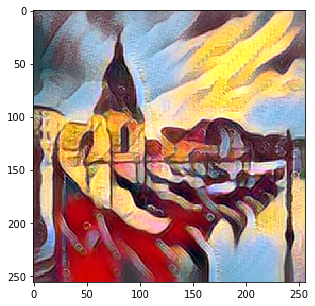

In [3]:
# 预测任务
result = model.predict(origin=["venice-boat.jpg"], style="candy.jpg", visualization=True, save_path ='style_tranfer')
plt.figure(figsize=(5,5))
plt.imshow(result[0][:,:,[2,1,0]])
plt.show()

题目3 （必做） ：完成1个迁移学习任务（30分）​​

In [4]:
import paddlehub.vision.transforms as T

transforms = T.Compose([T.Resize((256, 256)),
                        T.CenterCrop(224),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])],
                        to_rgb=True)
                        

In [6]:
from paddlehub.datasets import Flowers
from paddlehub.finetune.trainer import Trainer

flowers = Flowers(transforms)

flowers_validate = Flowers(transforms, mode='val')


In [7]:
model = hub.Module(name="resnet50_vd_imagenet_ssld", label_list=["roses", "tulips", "daisy", "sunflowers", "dandelion"])


load pretrained parameters success


In [8]:
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
trainer = Trainer(model, optimizer, checkpoint_dir='img_classification_ckpt')

# 算力有限，暂定为1
trainer.train(flowers, epochs=1, batch_size=32, eval_dataset=flowers_validate, save_interval=1)

[2022-03-25 17:29:58,859] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...
[2022-03-25 17:32:48,839] [   TRAIN] - Epoch=1/1, Step=10/92 loss=1.1661 acc=0.5625 lr=0.001000 step/sec=0.06 | ETA 00:26:03
[2022-03-25 17:35:32,764] [   TRAIN] - Epoch=1/1, Step=20/92 loss=1.2380 acc=0.5250 lr=0.001000 step/sec=0.06 | ETA 00:25:35
[2022-03-25 17:38:18,669] [   TRAIN] - Epoch=1/1, Step=30/92 loss=0.9454 acc=0.6500 lr=0.001000 step/sec=0.06 | ETA 00:25:32
[2022-03-25 17:41:03,834] [   TRAIN] - Epoch=1/1, Step=40/92 loss=0.7302 acc=0.7688 lr=0.001000 step/sec=0.06 | ETA 00:25:29
[2022-03-25 17:43:48,291] [   TRAIN] - Epoch=1/1, Step=50/92 loss=0.7928 acc=0.7188 lr=0.001000 step/sec=0.06 | ETA 00:25:26
[2022-03-25 17:46:33,598] [   TRAIN] - Epoch=1/1, Step=60/92 loss=0.7367 acc=0.7531 lr=0.001000 step/sec=0.06 | ETA 00:25:25
[2022-03-25 17:49:17,189] [   TRAIN] - Epoch=1/1, Step=70/92 loss=0.6621 acc=0.7625 lr=0.001000 step/sec=0.06 | ETA 00:25:22
[2022-03-25 17:52:03,406] 

In [1]:
import paddle
import paddlehub as hub

if __name__ == '__main__':

    model = hub.Module(name='resnet50_vd_imagenet_ssld', label_list=["roses", "tulips", "daisy", "sunflowers", "dandelion"], load_checkpoint='img_classification_ckpt/best_model/model.pdopt')
    result = model.predict(['candy.jpg'])
    print(result)


load custom parameters success
[{'dandelion': 1.0}]


题目四：完成1个demo服务化部署任务（30分）​​

In [2]:
!hub serving start -m resnet50_vd_imagenet_ssld


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
load pretrained parameters success
 * Serving Flask app "paddlehub.serving.app_compat" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://0.0.0.0:8866/ (Press CTRL+C to quit)
^C


In [ ]:
# 需要开两个终端运行

import requests
import json
import cv2
import base64

import numpy as np


def cv2_to_base64(image):
    data = cv2.imencode('.jpg', image)[1]
    return base64.b64encode(data.tostring()).decode('utf8')

def base64_to_cv2(b64str):
    data = base64.b64decode(b64str.encode('utf8'))
    data = np.fromstring(data, np.uint8)
    data = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return data

# 发送HTTP请求
org_im = cv2.imread('candy.jpg')

data = {'images':[cv2_to_base64(org_im)], 'top_k':2}
headers = {"Content-type": "application/json"}
url = "http://127.0.0.1:8866/predict/resnet50_vd_imagenet_ssld"
r = requests.post(url=url, headers=headers, data=json.dumps(data))
data =r.json()["results"]['data']
print(data)


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 